In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import os

# 数据集路径（根据实际结构修改）
base_dir = r'C:\Users\Administrator\PycharmProjects\深度学习日常练习项目\python深度学习红书\深度学习用于文本和序列\处理文本数据\使用词嵌入\imdb数据集\train'
texts = []
labels = []

# 遍历neg和pos子文件夹
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(base_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname.endswith('.txt'):
            # 拼接完整文件路径
            fpath = os.path.join(dir_name, fname)
            # 读取文件内容
            with open(fpath, encoding='utf-8') as f:
                texts.append(f.read())
            # 设置标签：neg为0，pos为1
            labels.append(0 if label_type == 'neg' else 1)

# 文本分词及序列转换
max_words = 10000  # 只考虑前10000个最常见的单词
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)  # 构建词表
sequences = tokenizer.texts_to_sequences(texts)  # 转换为整数序列

# 序列填充，统一长度
maxlen = 100
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)

# 输出信息验证
print(f'找到 {len(tokenizer.word_index)} 个独特的词汇')
print(f'数据张量形状: {data.shape}')
print(f'标签张量形状: {labels.shape}')

indices = np.arange(data.shape[0])
np.random.shuffle(indices)  # 打乱数据顺序
data = data[indices]
labels = labels[indices]

training_samples = 20000
validation_samples = 5000

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

# 加载GloVe词向量
glove_dir = r"C:\Users\Administrator\PycharmProjects\深度学习日常练习项目\python深度学习红书\深度学习用于文本和序列\处理文本数据\使用词嵌入\GloVe"

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.840B.300d.txt'), encoding='utf-8')
line_count = 0
error_lines = []  # 记录转换失败的行

for line in f:
    line_count += 1
    values = line.split()
    word = values[0]
    try:
        # 尝试将词向量部分转为float32数组
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except ValueError as e:
        # 捕获转换错误，记录该行
        error_lines.append((line_count, line.strip()))
        print(f"第{line_count}行转换失败: {e}")

f.close()
print(f'共加载 {len(embeddings_index)} 个词向量')

# 打印异常行示例（如果有）
if error_lines:
    print(f"\n共 {len(error_lines)} 行转换失败，前5条示例：")
    for i, (line_num, line_content) in enumerate(error_lines[:5]):
        print(f"第{line_num}行: {line_content}")

# 构建嵌入矩阵
embedding_dim = 300
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)  # 这里移除了多余的file:
        if embedding_vector is not None:
            # 如果单词不在GloVe词表中，则保持为0向量
            embedding_matrix[i] = embedding_vector


C:\Users\Administrator\anaconda3\envs\DeepLearning-py310\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


找到 88582 个独特的词汇
数据张量形状: (25000, 100)
标签张量形状: (25000,)
第52344行转换失败: could not convert string to float: '.'
第128262行转换失败: could not convert string to float: 'name@domain.com'
第151103行转换失败: could not convert string to float: '.'
第200669行转换失败: could not convert string to float: 'name@domain.com'
第209834行转换失败: could not convert string to float: '.'
第220780行转换失败: could not convert string to float: '.'
第253462行转换失败: could not convert string to float: 'name@domain.com'
第365746行转换失败: could not convert string to float: 'name@domain.com'
第532049行转换失败: could not convert string to float: 'name@domain.com'
第717303行转换失败: could not convert string to float: 'name@domain.com'
第994819行转换失败: could not convert string to float: 'name@domain.com'
第1123332行转换失败: could not convert string to float: 'Killerseats.com'
第1148410行转换失败: could not convert string to float: 'name@domain.com'
第1352111行转换失败: could not convert string to float: 'mylot.com'
第1499728行转换失败: could not convert string to float: 'name@domain.com'


In [3]:
# 构建模型
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words,embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          3000000   
                                                                 
 flatten (Flatten)           (None, 30000)             0         
                                                                 
 dense (Dense)               (None, 32)                960032    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,960,065
Trainable params: 3,960,065
Non-trainable params: 0
_________________________________________________________________


In [4]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False  # 冻结嵌入层


In [5]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=100, batch_size=200, validation_data=(x_val, y_val))

Epoch 1/100
100/100 [==============================] - 1s 2ms/step - loss: 0.6344 - accuracy: 0.6428 - val_loss: 0.5940 - val_accuracy: 0.7130
Epoch 2/100
100/100 [==============================] - 0s 2ms/step - loss: 0.4259 - accuracy: 0.8206 - val_loss: 0.4741 - val_accuracy: 0.7766
Epoch 3/100
100/100 [==============================] - 0s 2ms/step - loss: 0.3029 - accuracy: 0.8819 - val_loss: 0.4865 - val_accuracy: 0.7762
Epoch 4/100
100/100 [==============================] - 0s 2ms/step - loss: 0.2346 - accuracy: 0.9166 - val_loss: 0.5302 - val_accuracy: 0.7676
Epoch 5/100
100/100 [==============================] - 0s 2ms/step - loss: 0.1803 - accuracy: 0.9434 - val_loss: 0.5439 - val_accuracy: 0.7712
Epoch 6/100
100/100 [==============================] - 0s 2ms/step - loss: 0.1341 - accuracy: 0.9658 - val_loss: 0.6110 - val_accuracy: 0.7624
Epoch 7/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0962 - accuracy: 0.9811 - val_loss: 0.6392 - val_accuracy: 0.7614

In [6]:
model.save(r'C:\Users\Administrator\PycharmProjects\深度学习日常练习项目\python深度学习红书\深度学习用于文本和序列\处理文本数据\使用词嵌入\训练好的imdb模型\pre_trained_glove_model.h5')

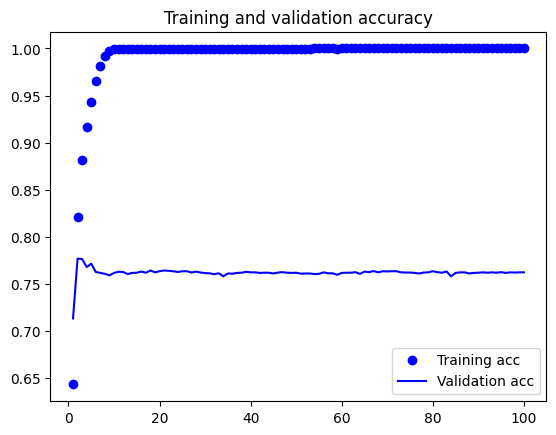

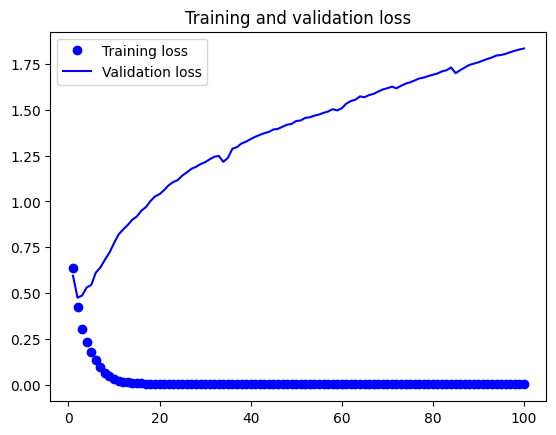

In [7]:
# 绘制结果
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

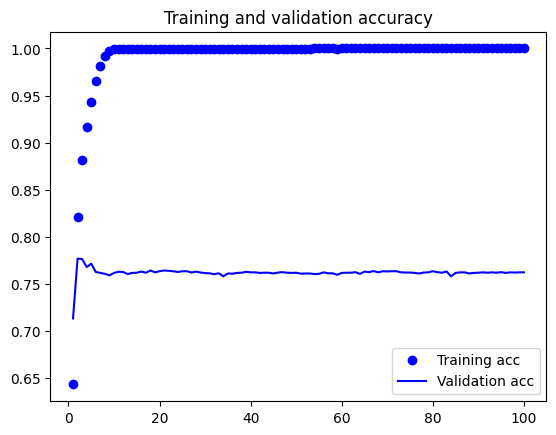

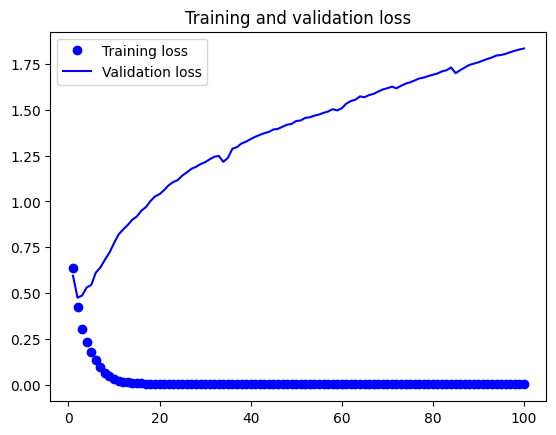

In [8]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [9]:
model.load_weights(r'C:\Users\Administrator\PycharmProjects\深度学习日常练习项目\python深度学习红书\深度学习用于文本和序列\处理文本数据\使用词嵌入\训练好的imdb模型\pre_trained_glove_model.h5')

In [10]:
model.evaluate(x_val, y_val)

157/157 [==============================] - 0s 1ms/step - loss: 1.8360 - accuracy: 0.7620


[1.8359546661376953, 0.7620000243186951]